<a href="https://colab.research.google.com/github/Joseph-Willem-Ricci/5450-final-project/blob/joe/CIS5450_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIT 5450 Final Project
Joanne Crean, Juan Goleniowski, Joseph Ricci

# Setup

Before running, be sure to create a new Kaggle API token and save it as 'kaggle.json' in your default Google Drive location (/content/drive/MyDrive/)

In [1]:
# Installs
%%capture
!pip install -q kaggle
!pip install pandasql
!pip install sqlalchemy==1.4.46

In [159]:
# Imports
import pandas as pd
import pandasql as ps
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
# Setup
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

Mounted at /content/drive


In [4]:
# Download Datasets
%%capture
# Spotify Top 200 and Viral 50 Charts for 2017 through 2021 Dataset
!!kaggle datasets download -d dhruvildave/spotify-charts

# Spotify Audio Features Datasets
!!kaggle datasets download -d rodolfofigueroa/spotify-12m-songs
!!kaggle datasets download -d muhmores/spotify-top-100-songs-of-20152019
!!kaggle datasets download -d sashankpillai/spotify-top-200-charts-20202021
!!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset
!!kaggle datasets download -d vatsalmavani/spotify-dataset
!!kaggle datasets download -d nandhakumarss/spotify-song-tracks
!!kaggle datasets download -d elemento/music-albums-popularity-prediction

# TikTok Popular Songs Dataset
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2019
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2020
!!kaggle datasets download -d sveta151/tiktok-popular-songs-2021

In [5]:
# Unzip Datasets
%%capture
!unzip /content/spotify-charts.zip
!unzip /content/spotify-12m-songs.zip
!unzip /content/spotify-top-100-songs-of-20152019.zip
!unzip /content/spotify-top-200-charts-20202021.zip
!unzip /content/-spotify-tracks-dataset.zip
!unzip /content/spotify-dataset.zip
!unzip /content/spotify-song-tracks.zip
!unzip /content/music-albums-popularity-prediction.zip
!unzip /content/tiktok-popular-songs-2019
!unzip /content/tiktok-popular-songs-2020
!unzip /content/tiktok-popular-songs-2021

In [6]:
# Clean up directory to save space
!rm sample_data/*
!rm -d sample_data
!rm ./*.zip
!rm sample_solution.csv
!rm ./*.xlsx

In [7]:
# Read the csv files and save them to pandas dataframes
df_charts = pd.read_csv('charts.csv')
df_song_features_1 = pd.read_csv('tracks_features.csv')
df_song_features_2 = pd.read_csv('Spotify 2010 - 2019 Top 100.csv')
df_song_features_3 = pd.read_csv('spotify_dataset.csv')
df_song_features_4 = pd.read_csv('dataset.csv')
df_song_features_5 = pd.read_csv('data/data.csv')
df_song_features_6 = pd.read_csv('SpotifyFeatures.csv')
df_song_features_7 = pd.read_csv('train.csv')  # contains three songs per row, expands to 8 and 9 below
df_song_features_10 = pd.read_csv('test.csv')  # contains three songs per row, expands to 11 and 12 below
df_tiktok_19 = pd.read_csv('TikTok_songs_2019.csv')
df_tiktok_20 = pd.read_csv('TikTok_songs_2020.csv')
df_tiktok_21 = pd.read_csv('TikTok_songs_2021.csv')

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Clean up remaining files
!rm data/*
!rm -d data
!rm ./*.csv

# Spotify Top 200 and Viral 50 Charts EDA

In [10]:
# Create a separate column for Year
df_charts['Year'] = df_charts['date'].str.extract(r'(\d{4})', expand=False)

# Cast 'Year' as Int
df_charts['Year'] = df_charts['Year'].astype(int)

# Show datatypes 
df_charts.dtypes

#remove ID, trend and streams columns
df_charts.drop(['url', 'trend', 'streams'], axis=1, inplace=True)

df_charts.dropna(inplace=True)

In [11]:
# Number of record per year
df_charts.groupby(by='Year').count()

,title,rank,date,artist,region,chart
Year,,,,,,
2017,4401145,4401145,4401145,4401145,4401145,4401145
2018,4863016,4863016,4863016,4863016,4863016,4863016
2019,5412658,5412658,5412658,5412658,5412658,5412658
2020,5793130,5793130,5793130,5793130,5793130,5793130
2021,5703536,5703536,5703536,5703536,5703536,5703536


In [12]:
# Songs and their highest ranking by year  # FIXME: *THE HIGHEST RANKING SONG FOR EACH ARTIST IN EACH YEAR*
#max_ranking_df = df_charts[df_charts['Year']<2019].groupby('artist', as_index=False).min('rank')
max_ranking_df = df_charts.groupby(['artist', 'Year'], as_index=False).min('rank')

In [13]:
max_ranking_df.head()

,artist,Year,rank
0,!!!,2017,11
1,"!!!, Lea Lea",2017,12
2,"""Elena Of Avalor"" Cast",2018,46
3,"""Weird Al"" Yankovic",2018,1
4,"""聲夢傳奇""學員",2021,12


In [14]:
# query = """SELECT artist, count(date) as 'days as number 1'
# FROM df_charts
# WHERE rank == 1
# GROUP BY artist
# ORDER BY count(date) DESC
# LIMIT 50
# """

# sql_top_50_artists = ps.sqldf(query, locals())

In [15]:
# sql_top_50_artists

In [16]:
# query = """SELECT title, count(date) as 'days as number 1'
# FROM df_charts
# WHERE rank == 1
# GROUP BY title
# ORDER BY count(date) DESC
# LIMIT 50
# """

# sql_top_50_songs = ps.sqldf(query, locals())

In [17]:
# sql_top_50_songs

# Spotify Audio Feature Dataset Wrangling and EDA

Since the Spotify Top 200 and Viral 50 charts dataset does not come with audio features the songs, there is no guarantee that we can find datasets that include audio features for all of the songs in the charts. One relevant question to explore is therefore

1. Can we find audio feature data for a suitably "big" fraction of the songs in the Charts dataset?

Additionally, since we'll be combining multiple audio features datasets, there is no guarantee that those datasets share the same features, so

2. What fields do the datasets share?

In [18]:
# First, since we want to find song features for as many of the songs in 'df_charts' as possible, let's start by
# projecting df_charts by song title and artist name, which will uniquely identify each song, and then dropping duplicates
df_charts_songs_artists = df_charts[['title', 'artist']].drop_duplicates()

# Next, let's join the features datasets on song title and artist name and see what percentage of songs in charts_df
# each song features dataset can provide features for

# Clean extranneous characters from artist columns if necessary
df_song_features_1['artists'] = df_song_features_1['artists'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_song_features_5['artists'] = df_song_features_5['artists'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_song_features_7['artists'] = df_song_features_7['artists'].str.replace(', ', '')
df_song_features_10['artists'] = df_song_features_10['artists'].str.replace(', ', '')

In [19]:
# Rename song title "title" and "artist" columns in each dataframe and 
# create separate dataframes for features_7 and features_10, which each have three columns for each field for three different songs
df_song_features_1 = df_song_features_1.rename(columns={'name': 'title', 'artists': 'artist'})
# _song_features_2 already has fields 'title' and 'artist'
df_song_features_3 = df_song_features_3.rename(columns={'Song Name': 'title', 'Artist': 'artist'})
df_song_features_4 = df_song_features_4.rename(columns={'track_name': 'title', 'artists': 'artist'})
df_song_features_5 = df_song_features_5.rename(columns={'name': 'title', 'artists': 'artist'})
df_song_features_6 = df_song_features_6.rename(columns={'track_name': 'title', 'artist_name': 'artist'})
df_song_features_8 = df_song_features_7.rename(columns={'t_name1': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name2', 't_dur0', 't_dur2', 't_dance0', 't_dance2', 't_energy0', 't_energy2', 't_key0', 't_key2', 't_mode0', 't_mode2', 't_speech0', 't_speech2', 't_acous0', 't_acous2', 't_ins0', 't_ins2', 't_live0', 't_live2', 't_val0', 't_val2', 't_tempo0', 't_tempo2', 't_sig0', 't_sig2'])
df_song_features_9 = df_song_features_7.rename(columns={'t_name2': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name1', 't_dur0', 't_dur1', 't_dance0', 't_dance1', 't_energy0', 't_energy1', 't_key0', 't_key1', 't_mode0', 't_mode1', 't_speech0', 't_speech1', 't_acous0', 't_acous1', 't_ins0', 't_ins1', 't_live0', 't_live1', 't_val0', 't_val1', 't_tempo0', 't_tempo1', 't_sig0', 't_sig1'])
df_song_features_7 = df_song_features_7.rename(columns={'t_name0': 'title', 'artists': 'artist'}).drop(columns=['t_name1', 't_name2', 't_dur1', 't_dur2', 't_dance1', 't_dance2', 't_energy1', 't_energy2', 't_key1', 't_key2', 't_mode1', 't_mode2', 't_speech1', 't_speech2', 't_acous1', 't_acous2', 't_ins1', 't_ins2', 't_live1', 't_live2', 't_val1', 't_val2', 't_tempo1', 't_tempo2', 't_sig1', 't_sig2'])
df_song_features_11 = df_song_features_10.rename(columns={'t_name1': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name2', 't_dur0', 't_dur2', 't_dance0', 't_dance2', 't_energy0', 't_energy2', 't_key0', 't_key2', 't_mode0', 't_mode2', 't_speech0', 't_speech2', 't_acous0', 't_acous2', 't_ins0', 't_ins2', 't_live0', 't_live2', 't_val0', 't_val2', 't_tempo0', 't_tempo2', 't_sig0', 't_sig2'])
df_song_features_12 = df_song_features_10.rename(columns={'t_name2': 'title', 'artists': 'artist'}).drop(columns=['t_name0', 't_name1', 't_dur0', 't_dur1', 't_dance0', 't_dance1', 't_energy0', 't_energy1', 't_key0', 't_key1', 't_mode0', 't_mode1', 't_speech0', 't_speech1', 't_acous0', 't_acous1', 't_ins0', 't_ins1', 't_live0', 't_live1', 't_val0', 't_val1', 't_tempo0', 't_tempo1', 't_sig0', 't_sig1'])
df_song_features_10 = df_song_features_10.rename(columns={'t_name0': 'title', 'artists': 'artist'}).drop(columns=['t_name1', 't_name2', 't_dur1', 't_dur2', 't_dance1', 't_dance2', 't_energy1', 't_energy2', 't_key1', 't_key2', 't_mode1', 't_mode2', 't_speech1', 't_speech2', 't_acous1', 't_acous2', 't_ins1', 't_ins2', 't_live1', 't_live2', 't_val1', 't_val2', 't_tempo1', 't_tempo2', 't_sig1', 't_sig2'])

# Project only the necessary columns from each feature dataset and also rename to maintain consistency
all_songs_with_features = pd.concat([df_song_features_1[['title', 'artist']], df_song_features_2[['title', 'artist']], 
                                     df_song_features_3[['title', 'artist']], df_song_features_4[['title', 'artist']], 
                                     df_song_features_5[['title', 'artist']], df_song_features_6[['title', 'artist']], 
                                     df_song_features_7[['title', 'artist']], df_song_features_8[['title', 'artist']], 
                                     df_song_features_9[['title', 'artist']], df_song_features_10[['title', 'artist']], 
                                     df_song_features_11[['title', 'artist']], df_song_features_12[['title', 'artist']]], ignore_index=True).drop_duplicates()

# Join on song title and artist name
feature_matches = pd.merge(df_charts_songs_artists, all_songs_with_features, on=['title', 'artist'], how='inner')

# Calculate the percentage of songs each features dataset was able to provide song features for
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 17.58% of songs in df_charts, for a total of 34720 out of 197533 songs


Lets now see whether we can do any additional cleaning to boost our match percentage. Since there are many obscure songs in df_charts that have, say, reached chart position 200 in small countries like Latvia and Ecuador, let us limit our search to songs that charted highly in the United States, and see if any of those songs were unmatched in the features data

In [20]:
non_matches = pd.merge(df_charts[df_charts['rank'] > 10][df_charts['region'] == 'United States'][['title', 'artist']], 
                                  all_songs_with_features, on=['title', 'artist'], how='left', indicator=True).drop_duplicates()
non_matches = non_matches[non_matches['_merge'] == 'left_only']
non_matches.head()

<ipython-input-20-b56ed4472038>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_matches = pd.merge(df_charts[df_charts['rank'] > 10][df_charts['region'] == 'United States'][['title', 'artist']],


,title,artist,_merge
3,X (feat. Future),"21 Savage, Metro Boomin",left_only
4,I Don’t Wanna Live Forever (Fifty Shades Darke...,"ZAYN, Taylor Swift",left_only
5,Don't Wanna Know,"Maroon 5, Kendrick Lamar",left_only
17,Sneakin’,"Drake, 21 Savage",left_only
32,Cold Water (feat. Justin Bieber & MØ),Major Lazer,left_only


In [21]:
# Does all_songs_with_features contain any of these songs but perhaps with a different format for title and artist?
print(all_songs_with_features[all_songs_with_features['artist'] == 'NLE Choppa, Roddy Ricch'])

                                   title                   artist
991025  Walk Em Down (feat. Roddy Ricch)  NLE Choppa, Roddy Ricch


This suggests that when there is a featured artist, the ordering of the artist names in the features datasets may be the opposite of the ordering in the charts dataset. Lets look at the other row with a featured artist.

In [22]:
print(all_songs_with_features[all_songs_with_features['artist'] == "Khalid, Summer Walker"])

                                title                 artist
1111433  Eleven (feat. Summer Walker)  Khalid, Summer Walker


In this case, the featured artist is not included in the 'artist' column in the charts dataset, but is in the features datasets. In joins so far, we have been joining on 'artist' and 'title' to be sure to uniquely identify each song. But since these songs with featured artists have varying formats in the 'artist' column, but the same format in the 'title' column, and since they are sure to be uniquely identified just by song title, let us try to filter by songs that have "(feat. " in their title, and join the charts and features datasets on 'title'.

In [23]:
charts_featured = df_charts_songs_artists[df_charts_songs_artists['title'].str.contains("\(feat\. ")][['title', 'artist']]
featured_feature_matches = pd.merge(charts_featured, all_songs_with_features, on=['title'], how='inner').drop_duplicates(subset='title')
featured_feature_matches = featured_feature_matches.rename(columns={'artist_x': 'artist'})
feature_matches = pd.concat([feature_matches, featured_feature_matches], ignore_index=True).drop_duplicates(subset = ['title', 'artist'])
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 18.44% of songs in df_charts, for a total of 36433 out of 197533 songs


In [24]:
feature_matches.head()

,title,artist,artist_y
0,Chantaje (feat. Maluma),Shakira,NaN
1,Reggaetón Lento (Bailemos),CNCO,NaN
2,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN
3,Shaky Shaky,Daddy Yankee,NaN
4,Traicionera,Sebastian Yatra,NaN


There is one more case that might result in two rows for the same song in different dataframes not to match. We can see that the song title is always the same for the same song between datasets, but we get into trouble when multiple artists are on the same song. This need not be when there is a "featured artist". So let us match on song title and when `all_songs_with_features['artist']` contains one artist that is contained as a substring in the artists in df_charts

In [25]:
# match df_charts and all_songs_with_features only on the title to start with. There will be many incorrect matches when two artists have songs by the same name
feature_charts_substr_match = pd.merge(df_charts_songs_artists, all_songs_with_features, on=['title'], how='inner')
feature_charts_substr_match['actual_match'] = feature_charts_substr_match[['artist_x', 'artist_y']].apply(lambda x: x['artist_y'].split(',')[0] in x['artist_x'] and x['artist_y'] != x['artist_x'], axis=1)
feature_charts_substr_match = feature_charts_substr_match[feature_charts_substr_match['actual_match'] == True].rename(columns={'artist_x': 'artist'})
feature_charts_substr_match.head()

,title,artist,artist_y,actual_match
0,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",True
3,Vente Pa' Ca (feat. Maluma),Ricky Martin,"Ricky Martin, Maluma",True
13,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,True
154,Otra vez (feat. J Balvin),Zion & Lennox,"Zion & Lennox, J Balvin",True
156,La Bicicleta,"Carlos Vives, Shakira",Carlos Vives,True


We can see here many songs that aren't necessarily "featured artist" songs, that have different formats in the artist column.

In [26]:
feature_charts_substr_match = feature_charts_substr_match.drop_duplicates(subset=['title', 'artist'])
feature_matches = pd.concat([feature_matches, feature_charts_substr_match], ignore_index=True).drop_duplicates()
feature_matches.drop(columns=['actual_match'], inplace=True)
match_percentage_combined = 100 * feature_matches.shape[0] / df_charts_songs_artists.shape[0]
print("We are able to provide audio features for " + str(round(match_percentage_combined,2)) + "% of songs in df_charts,"\
      " for a total of " + str(feature_matches.shape[0]) + " out of " + str(df_charts_songs_artists.shape[0]) + " songs")

We are able to provide audio features for 22.11% of songs in df_charts, for a total of 43673 out of 197533 songs


In [27]:
feature_matches.head()

,title,artist,artist_y
0,Chantaje (feat. Maluma),Shakira,NaN
1,Reggaetón Lento (Bailemos),CNCO,NaN
2,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN
3,Shaky Shaky,Daddy Yankee,NaN
4,Traicionera,Sebastian Yatra,NaN


Next, lets see what columns each of the features datasets share, and create one unified features dataset.

In [28]:
all_features_dfs = [df_song_features_1, df_song_features_2, df_song_features_3, df_song_features_4, df_song_features_5, df_song_features_6,
                    df_song_features_7, df_song_features_8, df_song_features_9, df_song_features_10, df_song_features_11, df_song_features_12]
for df in all_features_dfs:
    print([col for col in df.columns])

['id', 'title', 'album', 'album_id', 'artist', 'artist_ids', 'track_number', 'disc_number', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year', 'release_date']
['title', 'artist', 'top genre', 'year released', 'added', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop', 'top year', 'artist type']
['Index', 'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'title', 'Streams', 'artist', 'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted', 'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord']
['Unnamed: 0', 'track_id', 'artist', 'album_name', 'title', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',

Common columns:

title, artist, tempo, energy, danceability, liveness, valence, duration, acousticness, speechiness

In [29]:
features_1_rename_map = {}
features_2_rename_map = {'bpm': 'tempo', 'nrgy': 'energy', 'dnce': 'danceability', 'live': 'liveness', 'val': 'valence', 'dur': 'duration_ms', 'acous': 'acousticness', 'spch': 'speechiness'}
features_3_rename_map = {'Danceability': 'danceability', 'Energy': 'energy', 'Speechiness': 'speechiness', 'Acousticness': 'acousticness', 'Liveness': 'liveness', 'Tempo': 'tempo', 'Duration (ms)': 'duration_ms', 'Valence': 'valence'}
features_4_rename_map = {}
features_5_rename_map = {}
features_6_rename_map = {}
features_7_rename_map = {'t_dance0': 'danceability', 't_energy0': 'energy', 't_speech0': 'speechiness', 't_acous0': 'acousticness', 't_live0': 'liveness', 't_tempo0': 'tempo', 't_dur0': 'duration_ms', 't_val0': 'valence'}
features_8_rename_map = {'t_dance1': 'danceability', 't_energy1': 'energy', 't_speech1': 'speechiness', 't_acous1': 'acousticness', 't_live1': 'liveness', 't_tempo1': 'tempo', 't_dur1': 'duration_ms', 't_val1': 'valence'}
features_9_rename_map = {'t_dance2': 'danceability', 't_energy2': 'energy', 't_speech2': 'speechiness', 't_acous2': 'acousticness', 't_live2': 'liveness', 't_tempo2': 'tempo', 't_dur2': 'duration_ms', 't_val2': 'valence'}
features_10_rename_map = {'t_dance0': 'danceability', 't_energy0': 'energy', 't_speech0': 'speechiness', 't_acous0': 'acousticness', 't_live0': 'liveness', 't_tempo0': 'tempo', 't_dur0': 'duration_ms', 't_val0': 'valence'}
features_11_rename_map = {'t_dance1': 'danceability', 't_energy1': 'energy', 't_speech1': 'speechiness', 't_acous1': 'acousticness', 't_live1': 'liveness', 't_tempo1': 'tempo', 't_dur1': 'duration_ms', 't_val1': 'valence'}
features_12_rename_map = {'t_dance2': 'danceability', 't_energy2': 'energy', 't_speech2': 'speechiness', 't_acous2': 'acousticness', 't_live2': 'liveness', 't_tempo2': 'tempo', 't_dur2': 'duration_ms', 't_val2': 'valence'}

rename_maps = [features_1_rename_map, features_2_rename_map, features_3_rename_map, features_4_rename_map, features_5_rename_map, features_6_rename_map, 
               features_7_rename_map, features_8_rename_map, features_9_rename_map, features_10_rename_map, features_11_rename_map, features_12_rename_map]

for i in range(len(all_features_dfs)):
    all_features_dfs[i] = all_features_dfs[i].rename(columns=rename_maps[i])[['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']]

Check that all features dataframes have the same columns now:

In [30]:
for df in all_features_dfs:
    print([col for col in df.columns])

['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title', 'artist', 'duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
['title'

Now lets concatenate all of these features dataframes into one and do an inner join with `feature_matches`, the songs with features that are in `df_charts` to get the final, combined features dataset

In [31]:
df_features = pd.concat(all_features_dfs, axis=0, ignore_index=True)
df_features = df_features.dropna()
df_features_artist_format_1 = pd.merge(df_features, feature_matches, left_on=['title', 'artist'], right_on=['title', 'artist_y'], how='inner', suffixes=("", "_x"))  # 'artist' in the format of df_charts
df_features_artist_format_2 = pd.merge(df_features, feature_matches, on=['title', 'artist'], how='inner')  # 'artist' in the format of features dfs

In [32]:
df_features_artist_format_1.drop_duplicates(subset=['title', 'artist_y'], inplace=True)
df_features_artist_format_1.drop(columns=['artist', 'artist_y'], inplace=True)
df_features_artist_format_1.rename(columns={'artist_x': 'artist'}, inplace=True)
df_features_artist_format_2.drop_duplicates(subset=['title', 'artist'], inplace=True)
df_features_artist_format_2.drop(columns=['artist_y'], inplace=True)

In [33]:
df_features_artist_format_1.head()

,title,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,artist
0,Cry Baby (feat. DaBaby),137984,130.041,0.436,0.955,0.169,0.559,0.00527,0.38,Megan Thee Stallion
2,Do It On The Tip (feat. City Girls & Hot Girl ...,167370,97.543,0.526,0.944,0.0862,0.619,0.00281,0.289,Megan Thee Stallion
6,Movie (feat. Lil Durk),227375,152.062,0.728,0.896,0.128,0.877,0.00245,0.287,Megan Thee Stallion
10,Freaky Girls (feat. SZA),166906,93.952,0.666,0.816,0.156,0.25,0.000707,0.176,Megan Thee Stallion
14,Intercourse (feat. Popcaan & Mustard),197023,98.037,0.596,0.8,0.201,0.424,0.0775,0.239,Megan Thee Stallion


In [34]:
df_features_artist_format_2.head()

,title,artist,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,Guerrilla Radio,Rage Against The Machine,206200,103.68,0.957,0.599,0.155,0.489,0.0129,0.188
14,Sleep Now In the Fire,Rage Against The Machine,205600,127.059,0.929,0.426,0.0789,0.539,0.00162,0.0701
21,Killing In the Name,Rage Against The Machine,313667,86.573,0.779,0.457,0.0247,0.734,0.0185,0.257
24,Possession Obsession,Daryl Hall & John Oates,275960,114.822,0.532,0.757,0.1,0.896,0.119,0.0283
26,Swear It Again - Radio Edit,Westlife,247933,130.076,0.532,0.626,0.123,0.33,0.296,0.0276


In [35]:
df_features = pd.concat([df_features_artist_format_2, df_features_artist_format_1]).drop_duplicates(subset=['title', 'artist'])
df_features.reset_index(drop=True, inplace=True)
df_features.shape[0]

39638

In [36]:
df_features.head()

,title,artist,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,Guerrilla Radio,Rage Against The Machine,206200,103.68,0.957,0.599,0.155,0.489,0.0129,0.188
1,Sleep Now In the Fire,Rage Against The Machine,205600,127.059,0.929,0.426,0.0789,0.539,0.00162,0.0701
2,Killing In the Name,Rage Against The Machine,313667,86.573,0.779,0.457,0.0247,0.734,0.0185,0.257
3,Possession Obsession,Daryl Hall & John Oates,275960,114.822,0.532,0.757,0.1,0.896,0.119,0.0283
4,Swear It Again - Radio Edit,Westlife,247933,130.076,0.532,0.626,0.123,0.33,0.296,0.0276


Join with `df_charts` to get a unified dataframe with chart and feature columns

In [37]:
df_charts.head()

,title,rank,date,artist,region,chart,Year
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,top200,2017
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,top200,2017
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,top200,2017
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,top200,2017
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,top200,2017


In [38]:
# df_charts_features is all unique songs that we have audio features for, and their highest rank in all territories in all years
df_charts_features = pd.merge(df_charts.drop(columns=['date', 'region', 'chart']).groupby(by=['title', 'artist'], as_index=False).min(), df_features, on=['title', 'artist'], how='inner')
print("We have been able to find audio features for " + str(df_charts_features.shape[0]) + " unique songs.")

We have been able to find audio features for 39638 unique songs.


In [39]:
#Joanne added this cell to be able to download a CSV to get the new lyrics that we need

"""from google.colab import files
df_lyrics_list = df_charts_features[['artist', 'title']]

df_lyrics_list.to_csv('df_charts_features.csv')
files.download('df_charts_features.csv')
"""

"from google.colab import files\ndf_lyrics_list = df_charts_features[['artist', 'title']]\n\ndf_lyrics_list.to_csv('df_charts_features.csv')\nfiles.download('df_charts_features.csv')\n"

In [40]:
df_charts_features.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,!,O.S.T.R.,27,2018,221760,140.837,0.798,0.561,0.11,0.14,0.307,0.32
1,!!!,"nns, kkn, Ryu",5,2021,148378,82.203,0.76,0.808,0.207,0.774,0.0107,0.292
2,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.688,0.168,0.248
3,"""42"" - From SR3MM","Rae Sremmurd, Swae Lee, Slim Jxmmi",130,2018,238020,130.039,0.563,0.968,0.108,0.324,0.00275,0.125
4,"""99""",Barns Courtney,15,2018,199413,95.98,0.804,0.552,0.111,0.714,0.00598,0.0303


In [41]:
# keep the highest rank for each song in each territory per year
df_top200 = df_charts.query('chart == "top200"').drop(columns=['date','chart']).groupby(['title', 'artist', 'region', 'Year'], as_index=False).min()
df_viral50 = df_charts.query('chart == "viral50"').drop(columns=['date', 'chart']).groupby(['title', 'artist', 'region', 'Year'], as_index=False).min()

# df_top200_features and df_viral50_features contains a row for each song and its highest rank in each year and in each territory
df_top200_features = pd.merge(df_top200, df_features, on=['title', 'artist'], how='inner')
df_viral50_features = pd.merge(df_viral50, df_features, on=['title', 'artist'], how='inner')

In [42]:
df_top200_features.head()

,title,artist,region,Year,rank,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness
0,!,O.S.T.R.,Poland,2018,58,221760,140.837,0.798,0.561,0.11,0.14,0.307,0.32
1,!I'll Be Back!,Rilès,France,2018,139,178533,142.959,0.612,0.823,0.109,0.688,0.168,0.248
2,"""42"" - From SR3MM","Rae Sremmurd, Swae Lee, Slim Jxmmi",United States,2018,130,238020,130.039,0.563,0.968,0.108,0.324,0.00275,0.125
3,"""All That Is or Ever Was or Ever Will Be""",Alan Silvestri,Poland,2017,185,95720,73.37,0.139,0.292,0.32,0.0338,0.981,0.0354
4,"""All That Is or Ever Was or Ever Will Be""",Alan Silvestri,Turkey,2017,198,95720,73.37,0.139,0.292,0.32,0.0338,0.981,0.0354


# Constructing Artist Popularity Dataset

We will want to explore whether an artist's past success is a predictor of current success. In order to do so, we can count how many days each artist spent on the charts in each year.

In [43]:
# Copy Artist and Year from main df_charts_features table, one record per artist/Year combination
df_trend_ranking = df_charts_features[['artist','Year']].drop_duplicates()

In [44]:
# Add Best Ranking Position in all regions
df_trend_ranking = df_trend_ranking.merge(max_ranking_df, left_on=['artist','Year'], right_on=['artist','Year'], how='left')
df_trend_ranking.rename(columns={'rank':'Best_Ranking_Position'}, inplace=True)

In [45]:
# Calculate number of days trending in the US and in Rest of the World
days_trending_us = df_charts[df_charts['region']=='United States'].groupby(['artist', 'Year'], as_index=False)[['date']].count()
days_trending_row = df_charts[df_charts['region']!='United States'].groupby(['artist', 'Year'], as_index=False)[['date']].count()

In [46]:
# Add days trending to df_trend_ranking
df_trend_ranking = df_trend_ranking.merge(days_trending_us, left_on=['artist','Year'], right_on=['artist','Year'], how="left")
df_trend_ranking.rename(columns={'date':'Days_Trending_US'}, inplace=True)
df_trend_ranking = df_trend_ranking.merge(days_trending_row, left_on=['artist','Year'], right_on=['artist','Year'], how="left")
df_trend_ranking.rename(columns={'date':'Days_Trending_ROW', 'Year_y':'Year'}, inplace=True)

In [47]:
# Replace NaN for 0
df_trend_ranking[['Days_Trending_US', 'Days_Trending_ROW']]=df_trend_ranking[['Days_Trending_US', 'Days_Trending_ROW']].fillna(0)

In [48]:
# Final table with artist, top position across all regions, and days trending in the US and ROW - change for git
df_trend_ranking.head()

,artist,Year,Best_Ranking_Position,Days_Trending_US,Days_Trending_ROW
0,O.S.T.R.,2018,3,0.0,351.0
1,"nns, kkn, Ryu",2021,5,0.0,44.0
2,Rilès,2018,2,0.0,195.0
3,"Rae Sremmurd, Swae Lee, Slim Jxmmi",2018,2,430.0,4398.0
4,Barns Courtney,2018,15,0.0,19.0


# TikTok Popular Songs Dataset Wrangling and EDA

In [49]:
df_tiktok_19.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Shake It,Metro Station,53,Metro Station,68,0.618,0.955,-3.836,1,4,0.0798,0.00221,0.000003,0.486,0.790,150.034,4,179947
1,Chinese New Year,SALES,61,SALES - EP,53,0.744,0.845,-7.422,0,4,0.2530,0.75900,0.232000,0.100,0.749,75.221,4,160000
2,Baby I'm Yours,Breakbot,57,By Your Side,69,0.829,0.792,-3.755,0,2,0.0668,0.72600,0.000006,0.122,0.758,118.050,4,215507
3,The Git Up,Blanco Brown,60,The Git Up,2,0.847,0.678,-8.635,1,9,0.1090,0.06690,0.000000,0.274,0.811,97.984,4,200594
4,Say Hey (I Love You),Michael Franti & Spearhead,58,All Rebel Rockers,0,0.738,0.983,-4.374,0,5,0.0855,0.03800,0.000006,0.183,0.957,92.998,4,235760


In [50]:
df_tiktok_20.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,Say So,Doja Cat,88,Hot Pink,80,0.787,0.673,-4.583,0,11,0.1590,0.26400,0.000003,0.0904,0.779,110.962,4,237893
1,Blinding Lights,The Weeknd,93,After Hours,90,0.514,0.730,-5.934,1,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,200040
2,Supalonely (feat. Gus Dapperton),BENEE,67,Hey u x,63,0.862,0.631,-4.746,1,7,0.0515,0.29100,0.000209,0.1230,0.841,128.978,4,223488
3,Savage,Megan Thee Stallion,82,Suga,70,0.843,0.741,-5.609,1,11,0.3340,0.02520,0.000000,0.0960,0.680,168.983,4,155497
4,Moral of the Story,Ashe,68,Moral of the Story,76,0.572,0.406,-8.624,1,10,0.0427,0.58700,0.000004,0.1020,0.265,119.812,4,201084


In [51]:
df_tiktok_21.head()

,track_name,artist_name,artist_pop,album,track_pop,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
0,STAY (with Justin Bieber),The Kid LAROI,83,STAY (with Justin Bieber),89,0.591,0.764,-5.484,1,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928,4,141806
1,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,90,Justice,86,0.677,0.696,-6.181,1,0,0.1190,0.3210,0.000000,0.4200,0.464,90.030,4,198082
2,edamame (feat. Rich Brian),bbno$,72,edamame (feat. Rich Brian),77,0.815,0.848,-4.704,0,4,0.1150,0.0230,0.000162,0.0265,0.684,106.032,4,133707
3,Here's Your Perfect,Jamie Miller,65,Here's Your Perfect,77,0.558,0.454,-5.335,1,6,0.0551,0.4990,0.000000,0.1460,0.424,113.120,4,158594
4,It's You,Sezairi,57,It's You,73,0.630,0.456,-8.285,1,8,0.0317,0.5450,0.000000,0.1140,0.166,137.915,3,251440


In [52]:
# Combine the tiktok datasets
data_tiktok = [df_tiktok_19, df_tiktok_20, df_tiktok_21]
df_tiktok_full = pd.concat(data_tiktok)

In [53]:
# Extract the track name and artist to check for the overlap
df_tiktok_tracks = df_tiktok_full[['track_name', 'artist_name']]

# Check number of rows
df_tiktok_tracks.shape[0]

705

In [54]:
# Merge with spotify features on track names only to check overlap
df_tiktok_tracks_only = feature_matches.merge(df_tiktok_tracks.drop_duplicates(), left_on = ['title'], right_on=['track_name'], how='inner')

# Check overlap
df_tiktok_tracks_only.shape[0]

936

In [55]:
# Review rows that didn't match to see if there's more clean-up that can be done 
df_tiktok_full_merge = feature_matches.merge(df_tiktok_tracks.drop_duplicates(), left_on = ['title'], right_on=['track_name'], how='outer', indicator = True)

In [56]:
df_tiktok_full_merge.head()

,title,artist,artist_y,track_name,artist_name,_merge
0,Chantaje (feat. Maluma),Shakira,NaN,NaN,NaN,left_only
1,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",NaN,NaN,left_only
2,Reggaetón Lento (Bailemos),CNCO,NaN,NaN,NaN,left_only
3,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN,NaN,NaN,left_only
4,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,NaN,NaN,left_only


In [57]:
# Review rows that didn't match to see if there's more clean-up that can be done 
df_tiktok_full_merge[df_tiktok_full_merge['_merge'] != 'both']

,title,artist,artist_y,track_name,artist_name,_merge
0,Chantaje (feat. Maluma),Shakira,NaN,NaN,NaN,left_only
1,Chantaje (feat. Maluma),Shakira,"Shakira, Maluma",NaN,NaN,left_only
2,Reggaetón Lento (Bailemos),CNCO,NaN,NaN,NaN,left_only
3,Safari,"J Balvin, Pharrell Williams, BIA, Sky",NaN,NaN,NaN,left_only
4,Safari,"J Balvin, Pharrell Williams, BIA, Sky",J Balvin,NaN,NaN,left_only
...,...,...,...,...,...,...
43837,NaN,NaN,NaN,Teenage Dream,Katy Perry,right_only
43838,NaN,NaN,NaN,Favorite Girl,Justin Bieber,right_only
43839,NaN,NaN,NaN,Love Tonight - David Guetta Remix Edit,Shouse,right_only
43840,NaN,NaN,NaN,Polaroid Love,ENHYPEN,right_only


In [58]:
# do a check to see if I convert the track names to lower case, could I get more matches 
df_tiktok_full_merge.dropna(inplace = True)
df_tiktok_full_merge['title_l'] = df_tiktok_full_merge.apply(lambda x : x['title'].lower(), axis =1)
df_tiktok_full_merge['track_name_l'] = df_tiktok_full_merge.apply(lambda x : x['track_name'].lower(), axis =1)

print(df_tiktok_full_merge[(df_tiktok_full_merge['title_l'] == df_tiktok_full_merge['track_name_l']) & (df_tiktok_full_merge['_merge'] != 'both')])

# prints an empty dataframe so the conclusion is that no I can't

Empty DataFrame
Columns: [title, artist, artist_y, track_name, artist_name, _merge, title_l, track_name_l]
Index: []


In [59]:
# Create a match column to indicate cases where the tiktok artist name can be found as a substring in the spotify artist column 
df_tiktok_tracks_only['match'] = df_tiktok_tracks_only.apply(lambda x: x['artist_name'].lower().find(x['artist'].lower()), axis=1).ge(0)

# Create a match column to indicate cases where the spotify artist column can be found as a substring in the tiktok artist name 
df_tiktok_tracks_only['match_2'] = df_tiktok_tracks_only.apply(lambda x: x['artist'].lower().find(x['artist_name'].lower()), axis=1).ge(0)

In [60]:
# review data to see which rows have matched
df_tiktok_tracks_only[df_tiktok_tracks_only['match'] |df_tiktok_tracks_only['match_2']]

,title,artist,artist_y,track_name,artist_name,match,match_2
2,Please Don't Go,Mike Posner,NaN,Please Don't Go,Mike Posner,True,True
4,Panda,Desiigner,NaN,Panda,Desiigner,True,True
6,Caroline,Aminé,NaN,Caroline,Aminé,True,True
8,Middle,"DJ Snake, Bipolar Sunshine",NaN,Middle,DJ Snake,False,True
9,Middle,"DJ Snake, Bipolar Sunshine",DJ Snake,Middle,DJ Snake,False,True
...,...,...,...,...,...,...,...
931,The Weekend - Funk Wav Remix,"SZA, Calvin Harris","SZA, Calvin Harris, Funk Wav",The Weekend - Funk Wav Remix,SZA,False,True
932,WTF,"Young Spool, JAKOB",Young Spool,WTF,Young Spool,False,True
933,Give Love,"AKMU, 서기, 신승익, 이찬혁, LEE SUHYUN",AKMU,Give Love,AKMU,False,True
934,Crimewave,"Crystal Castles, HEALTH",Crystal Castles,Crimewave,Crystal Castles,False,True


In [61]:
# review data to see which rows have not matched
df_tiktok_tracks_only[(df_tiktok_tracks_only['match'] == False) & (df_tiktok_tracks_only['match_2'] == False)]

,title,artist,artist_y,track_name,artist_name,match,match_2
0,Please Don't Go,Joel Adams,NaN,Please Don't Go,Mike Posner,False,False
1,Please Don't Go,Double You,NaN,Please Don't Go,Mike Posner,False,False
3,Please Don't Go,Marcus & Martinus,NaN,Please Don't Go,Mike Posner,False,False
5,Panda,"Almighty, Farruko",Almighty,Panda,Desiigner,False,False
7,Caroline,Animal Years,NaN,Caroline,Aminé,False,False
...,...,...,...,...,...,...,...
876,Sunshine,OneRepublic,NaN,Sunshine,Ant Beale,False,False
877,Sunshine,"David Guetta, Avicii",David Guetta,Sunshine,Ant Beale,False,False
897,Take It Off,The Donnas,NaN,Take It Off,Kesha,False,False
900,Tonight You Belong To Me,"Eddie Vedder, Cat Power",NaN,Tonight You Belong To Me,Patience & Prudence,False,False


In [62]:
# check the rows where the artists names aren't an exact match - for visual inspection 
df_tiktok_tracks_only.loc[(df_tiktok_tracks_only['artist'] != df_tiktok_tracks_only['artist_name']) & (df_tiktok_tracks_only['match'] |df_tiktok_tracks_only['match_2'])]

,title,artist,artist_y,track_name,artist_name,match,match_2
8,Middle,"DJ Snake, Bipolar Sunshine",NaN,Middle,DJ Snake,False,True
9,Middle,"DJ Snake, Bipolar Sunshine",DJ Snake,Middle,DJ Snake,False,True
14,No Lie,"Sean Paul, Dua Lipa",NaN,No Lie,Sean Paul,False,True
15,No Lie,"Sean Paul, Dua Lipa",Sean Paul,No Lie,Sean Paul,False,True
40,We Found Love,"Rihanna, Calvin Harris",NaN,We Found Love,Rihanna,False,True
...,...,...,...,...,...,...,...
931,The Weekend - Funk Wav Remix,"SZA, Calvin Harris","SZA, Calvin Harris, Funk Wav",The Weekend - Funk Wav Remix,SZA,False,True
932,WTF,"Young Spool, JAKOB",Young Spool,WTF,Young Spool,False,True
933,Give Love,"AKMU, 서기, 신승익, 이찬혁, LEE SUHYUN",AKMU,Give Love,AKMU,False,True
934,Crimewave,"Crystal Castles, HEALTH",Crystal Castles,Crimewave,Crystal Castles,False,True


In [63]:
# Create a dataframe of overlapping songs based on the two matches colums and drop duplicates
df_tiktok_matches_final = df_tiktok_tracks_only.loc[(df_tiktok_tracks_only['match'] |df_tiktok_tracks_only['match_2'])]

# Check the shape of the df 
df_tiktok_matches_final.shape[0]

573

In [64]:
# spot check an artist to see if the name matching looks appropriate 
df_tiktok_matches_final.loc[(df_tiktok_matches_final['artist_name'] == "Justin Bieber" )|( df_tiktok_matches_final['artist'] == "Justin Bieber" )]

,title,artist,artist_y,track_name,artist_name,match,match_2
279,Baby,"Justin Bieber, Ludacris",NaN,Baby,Justin Bieber,False,True
285,Baby,"Justin Bieber, Ludacris",Justin Bieber,Baby,Justin Bieber,False,True
464,Hold On,Justin Bieber,NaN,Hold On,Justin Bieber,True,True
554,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,NaN,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,True,True
624,Ghost,Justin Bieber,NaN,Ghost,Justin Bieber,True,True


In [65]:
# drop rows that are no longer needed
df_tiktok_matches_final.drop(['match', 'match_2', 'track_name', 'artist_name','artist_y'], inplace =True, axis=1)

# add a column to indicate tiktok popularity 
df_tiktok_matches_final= df_tiktok_matches_final.assign(tiktok_pop = 1)

<ipython-input-65-42476efdcff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tiktok_matches_final.drop(['match', 'match_2', 'track_name', 'artist_name','artist_y'], inplace =True, axis=1)


In [66]:
df_tiktok_matches_final.head()

,title,artist,tiktok_pop
2,Please Don't Go,Mike Posner,1
4,Panda,Desiigner,1
6,Caroline,Aminé,1
8,Middle,"DJ Snake, Bipolar Sunshine",1
9,Middle,"DJ Snake, Bipolar Sunshine",1


In [67]:
df_tiktok_matches_final.groupby(['tiktok_pop']).count()

,title,artist
tiktok_pop,,
1,573,573


In [68]:
df_charts_features_tiktok = pd.merge(df_charts_features, df_tiktok_matches_final, on=['title', 'artist'], how='left')
df_charts_features_tiktok['tiktok_pop'] = df_charts_features_tiktok['tiktok_pop'].apply(lambda x: x if x == 1 else 0)

Lets inspect the dataframe of merged charts, features and tiktok data to see if there is any final cleaning to do:

In [69]:
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['artist'] == 'Ariana Grande')][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
418,34+35,Ariana Grande,1,2020,,,,,,,,,1.0
551,7 rings,Ariana Grande,1,2019,179.0,140.0,32.0,78.0,9.0,33.0,59.0,33.0,1.0
30316,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0


We can see that some rows has features that are formatted differently than the rest. If you expand the dataframe you can see that there are many more rows like that. These rows are formatted as percentages rather than decimals between 0 and 1, so we can run an apply function to change the format of any such row. We can also see that `duration_ms` is formatted as seconds in such rows, so we should edit that as well. And finally we can also see that some rows have empty features values, so we should drop those.

In [70]:
# drop rows with emtpy features values
mask = df_charts_features_tiktok['energy'].str.strip() == ''
df_charts_features_tiktok = df_charts_features_tiktok[~mask].copy()

# convert formats of features columns with percentages to floats between 0 and 1
cols = ['danceability',	'energy',	'speechiness',	'acousticness', 'liveness',	'valence']
for col in cols:
  df_charts_features_tiktok[col] = df_charts_features_tiktok[col].apply(lambda x: float(x) / 100 if float(x) > 1 else float(x))

# convert format of duration columns in seconds to ms
df_charts_features_tiktok['duration_ms'] = df_charts_features_tiktok['duration_ms'].apply(lambda x: int(x) * 1000 if int(x) < 10000 else int(x))
df_charts_features_tiktok[(df_charts_features_tiktok['tiktok_pop'] == 1) & (df_charts_features_tiktok['artist'] == 'Ariana Grande')][0:3]

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop
551,7 rings,Ariana Grande,1,2019,179000,140.0,0.32,0.780,0.090,0.330,0.590,0.3300,1.0
30316,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0
30317,Stuck with U (with Justin Bieber),Ariana Grande,1,2020,228482,178.765,0.45,0.597,0.382,0.537,0.223,0.0418,1.0


And we can see that there are still some duplicates

In [71]:
df_charts_features_tiktok.drop_duplicates(inplace=True)
df_charts_features_tiktok.shape[0]

39627

Convert tempo column to float

In [72]:
df_charts_features_tiktok['tempo'] = df_charts_features_tiktok['tempo'].apply(lambda x: float(x))
df_charts_features_tiktok['tempo'] = df_charts_features_tiktok['tempo'].astype('float64')

And lets do the same for `df_top200_features` and `df_viral50_features` in case there are any such rows in there too.

In [73]:
# drop rows with emtpy features values
mask1 = df_top200_features['energy'].str.strip() == ''
mask2 = df_viral50_features['energy'].str.strip() == ''
df_top200_features = df_top200_features[~mask1].copy()
df_viral50_features = df_viral50_features[~mask2].copy()

# convert formats of features columns with percentages to floats between 0 and 1
cols = ['danceability',	'energy',	'speechiness',	'acousticness', 'liveness',	'valence']
for col in cols:
  df_top200_features[col] = df_top200_features[col].apply(lambda x: float(x) / 100 if float(x) > 1 else float(x))
  df_viral50_features[col] = df_viral50_features[col].apply(lambda x: float(x) / 100 if float(x) > 1 else float(x))

# convert tempo column to float
df_top200_features['tempo'] = df_top200_features['tempo'].apply(lambda x: float(x))
df_top200_features['tempo'] = df_top200_features['tempo'].astype('float64')
df_viral50_features['tempo'] = df_viral50_features['tempo'].apply(lambda x: float(x))
df_viral50_features['tempo'] = df_viral50_features['tempo'].astype('float64')

# convert format of duration columns in seconds to ms
df_top200_features['duration_ms'] = df_top200_features['duration_ms'].apply(lambda x: int(x) * 1000 if int(x) < 10000 else int(x))
df_viral50_features['duration_ms'] = df_viral50_features['duration_ms'].apply(lambda x: int(x) * 1000 if int(x) < 10000 else int(x))

# drop duplicates
df_top200_features.drop_duplicates(inplace=True)
df_viral50_features.drop_duplicates(inplace=True)

# Genius Lyrics Dataset Creation and EDA

We want to find lyrics for our songs so that we can include these in our dataset. 

The [lyricsgenius](https://) library will be used. This library makes it easier to extract lyrics quickly from the lyrics website [Genius](https://). 

In [74]:
!pip install lyricsgenius

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 6.3 MB/s eta 0:00:00


**JOE:** I'm confused about what this is below @Joanne. For downloading df that is created above? For faster run time writing code? Will the TA need to run this?

In [75]:
"""
# this cell is used for downloading csv
from google.colab import files
feature_matches.to_csv('combined_features.csv') 
files.download('combined_features.csv')"""

"\n# this cell is used for downloading csv\nfrom google.colab import files\nfeature_matches.to_csv('combined_features.csv') \nfiles.download('combined_features.csv')"

In [76]:
import lyricsgenius
import os
import spacy
import re
from datetime import datetime

To use the lyricsgenius library we needed to sign-up for an account that authorizes access to the Genius API. The Genius account provides a access_token that is required by the lyricsgenius package. The cell below includes the required credentials.



In [77]:
client_id = 'TS15U5iwbWLGkhfGFVqnOuDA9mVjJhhLlXpJDYai6nm79S9JWFzznlsQN5dCFuZG'
client_secret = 'SOhrXQxD9YZ2RxBQwR-wwu5Zbxh6UgkfuIEaUJltx9L9h8aynN5zZ9Jsm1JNlh_5Npu_uev1MKorJV_A6MVYKw'
access_token = 'US00oQ6_8lkhwRjHAOudB62bruf1B3JGOGuHR8V8zeawxpoc8fcA9QGXQ3bhYWu-'
website_url = 'https://github.com/Joseph-Willem-Ricci/5450-final-project'

It wasn't possible to use the lyricsgenius package directly from colab because the connection was blocked due to security restrictions. Instead, the code below was run locally to extract lyrics for the songs that we had in the final
`df_charts_features` dataframe. 

```python
# pull in the csv of songs to search for
df_combined_features = pd.read_csv('combined_features.csv')

# initialise the API, make sure that it will retry if a request fails, remove headers that 
# demarcate the song, e.g. 'chorus', 'verse'
api = lyricsgenius.Genius(access_token, retries = 500, remove_section_headers = True)


# initialise a dataframe to store the results
all_song_data = pd.DataFrame()

# track time because this query takes a long time to run, e.g. 24 hours 
start_time = datetime.now()

# as we loop through and search, print some info about progress because it's going to run for so long
print("Started at {}".format(start_time))
for i in range((1924+3678), len(df_combined_features)):
    rolling_pct = int((i/len(df_combined_features))*100)
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(df_combined_features))+ "." + " Currently collecting " + 
          df_combined_features.iloc[i]['title'] + " by " + df_combined_features.iloc[i]['artist'] + " "*50, end="\r")
    
    # store the song information that we already have in our csv
    song_title = df_combined_features.iloc[i]['title']
    song_title = re.sub(" and ", " & ", song_title)
    artist_name = df_combined_features.iloc[i]['artist']
    artist_name = re.sub(" and ", " & ", artist_name)

    # search for the lyrics and song url, we don't want a crash if a song's details can't be found so use a try catch block
    try:
        song = api.search_song(song_title, artist=artist_name)
        song_lyrics = re.sub("\n", " ", song.lyrics) #Remove newline breaks, we won't need them.
        song_url = song.url
    except:
        song_lyrics = "null"
        song_url = "null"

    # create a row in the dataframe with the final info that we found for a song    
    row = {
        "title": df_combined_features.iloc[i]['title'],
        "artist": df_combined_features.iloc[i]['artist'],
        "lyrics": song_lyrics,
        "song URL": song_url,
    }

    # add a row to the dataframe
    all_song_data = all_song_data.append(row, ignore_index=True)

    # update csv - decided to do this for every song incase there was a crash during the run
    all_song_data.to_csv("all_song_data_final.csv")

# print out final time to run
end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))
```


This process resulted in multiple files being generated because I ran batches as we got figured out how to expand our base data set. These were merged into a final CSV.

The final CSV generated contained some bad quality data. I cleaned the file locally before uploading it to Kaggle to be imported into this notebook.

The cleaning steps were determined by analysing the data extracted:
1.   I noticed that some rows had no lyrics so these were dropped. 
2.   Some rows had odd URLs, when I looked these up I realised that they were articles about the song. I inspected to find a pattern that I could use to determine which rows should be deleted. In the end, it seemed best to compare the first two characters in the url with the first two characters of the artist's name. If they didn't match these rows were dropped. 


I created a project on Kaggle and uploaded the lyrics csv to that. This could then be downloaded into this notebook.

```python
# merge the different CSVs
df_lyrics_1 = pd.read_csv('all_song_data_final.csv', low_memory=False)
df_lyrics_2 = pd.read_csv('all_song_data_final_2.csv', low_memory=False)
df_lyrics_3 = pd.read_csv('all_song_data_final_3.csv', low_memory=False)
df_lyrics_4 = pd.read_csv("all_song_data_final_4.csv", low_memory=False)
df_lyrics_5 = pd.read_csv("all_song_data_final_5.csv", low_memory=False)

lyrics_list = [df_lyrics_1, df_lyrics_2, df_lyrics_3,df_lyrics_4]
df_lyrics = pd.concat(lyrics_list)

# check size of dataframe
print(df_lyrics.shape)

# drop duplicate rows
print(df_lyrics[df_lyrics['song URL'].isna()])
df_lyrics.drop_duplicates(inplace = True)

# check dataframe
df_lyrics.head()

# remove rows where the URL is incorrect - in some cases the lyrics was actually an article about the song 
# tried to find patterns before finally matching on first two letters

# first thought that the strange rows always had the word 'annotated', 'chapter' or 'discography' in URL but this wasn't true
print(df_lyrics[~df_lyrics['song URL'].str.contains('annotated')])
print(df_lyrics[~df_lyrics['song URL'].str.contains('chapter')])
print(df_lyrics_two = df_lyrics[~df_lyrics['song URL'].str.contains('discography')])

# dropped unnecessary columns
df_lyrics = df_lyrics[['title', 'artist', 'lyrics', 'song URL']]

## created new columns for the URL and artist so that I could compare them  
df_lyrics['clean URL'] = df_lyrics['song URL'].str.replace('-', '').str.lower()
df_lyrics['clean artist'] = df_lyrics['artist'].str.replace(' ', '').str.lower()

# extracted first two letters of artist from URL
df_lyrics['URL letters'] = df_lyrics['clean URL'].str.extract(r'https://genius\.com/(\w{2})')

# found rows where there was a match between artist and URL
df_lyrics_two = df_lyrics.loc[df_lyrics['URL letters'] == df_lyrics['clean artist'].str[:2]]
print(df_lyrics_two.head(50))

# sense check by printing the rows that didn't match to see if my matching worked
df_lyrics_three = df_lyrics.loc[df_lyrics['URL letters'] != df_lyrics['clean artist'].str[:2]]
print(df_lyrics_three.head(50))

# created the final csv to upload to Kaggle
df_lyrics_two.to_csv("all_song_data_complete_V4.csv", encoding="utf-8")
```

In [78]:
%%capture
!!kaggle datasets download -d joannecrean/spotify-songs-lyrics
!unzip /content/spotify-songs-lyrics.zip

## Sentiment analysis on lyrics

Sentiment analysis was run on the lyrics and this was stored in the final lyrics CSV. 



In [79]:
%%capture
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stopwords = set(stopwords.words(['english', 'spanish', 'german','french']))


In [80]:
df_lyrics = pd.read_csv('all_song_data_complete_V4.csv')

I created a CSV of sensitive words that are often in songs but may be easily misintepreted easily. I ran this locally because I didn't want to write this list into my notebook as the words may offend the reader. The ```sensitive.py``` maye be found the [project github repo](https://). The code run is below. 

This sensitive words CSV was also added to the github repo. 


In [81]:
sensitive_words = pd.read_csv('sensitive_words.csv')
sensitive_words = sensitive_words.values.tolist()

```python
sensitive_words = ['list of sensitive words']
words_ser = pd.Series(sensitive_words)
words_ser.to_csv("sensitive_words.csv")
```

In [82]:
def tokenize_content(content):
  content = content.lower() #convert to lowercase
  content_tokens = nltk.word_tokenize(content) # tokenise
  alpha_tokens = [w for w in content_tokens if w.isalpha()] # keep alpha tokens
  stop_tokens = [t for t in alpha_tokens if not t in stopwords] #remove if stopword
  final_tokens = [s for s in stop_tokens if not s in sensitive_words] #remove if sensitive
  #print(final_tokens)
  return final_tokens

In [83]:
df_lyrics.head()

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters
0,0,Ride It,Regard,"Ride It Lyrics Ride it, we're all alone Ride ...",https://genius.com/Regard-ride-it-lyrics,https://genius.com/regardrideitlyrics,regard,re
1,1,25-Aug,Bad Bunny,"TranslationsDeutschEnglish25/8 Lyrics Eh, ey ...",https://genius.com/Bad-bunny-25-8-lyrics,https://genius.com/badbunny258lyrics,badbunny,ba
2,2,Keii,Anuel AA,Keii Lyrics Ella ya no piensa en él (En él) É...,https://genius.com/Anuel-aa-keii-lyrics,https://genius.com/anuelaakeiilyrics,anuelaa,an
3,3,Hei rakas,BEHM,Hei rakas Lyrics Mistä alkaisin jos susta kert...,https://genius.com/Behm-hei-rakas-lyrics,https://genius.com/behmheirakaslyrics,behm,be
4,4,GOOBA,6ix9ine,TranslationsTürkçeEspañolHrvatskiРусскийPortug...,https://genius.com/6ix9ine-gooba-lyrics,https://genius.com/6ix9inegoobalyrics,6ix9ine,6i


In [84]:
len(df_lyrics)

30427

In [85]:
df_lyrics.dropna(inplace = True)

In [86]:
# remove the intro text before the lyrics 
df_lyrics['lyrics'] = [re.sub('^.*Lyrics', '', x) for x in df_lyrics['lyrics']]

In [87]:
len(df_lyrics)

30427

In [88]:
df_lyrics.head()

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters
0,0,Ride It,Regard,"Ride it, we're all alone Ride it, just lose ...",https://genius.com/Regard-ride-it-lyrics,https://genius.com/regardrideitlyrics,regard,re
1,1,25-Aug,Bad Bunny,"Eh, ey Yo sigo siendo el mismo, yo no he cam...",https://genius.com/Bad-bunny-25-8-lyrics,https://genius.com/badbunny258lyrics,badbunny,ba
2,2,Keii,Anuel AA,Ella ya no piensa en él (En él) Él la convir...,https://genius.com/Anuel-aa-keii-lyrics,https://genius.com/anuelaakeiilyrics,anuelaa,an
3,3,Hei rakas,BEHM,Mistä alkaisin jos susta kertoisin Joku toine...,https://genius.com/Behm-hei-rakas-lyrics,https://genius.com/behmheirakaslyrics,behm,be
4,4,GOOBA,6ix9ine,"I tell a nigga don't dick ride, don't blick r...",https://genius.com/6ix9ine-gooba-lyrics,https://genius.com/6ix9inegoobalyrics,6ix9ine,6i


In [89]:
df_lyrics['tokenized'] = df_lyrics.apply(lambda x: tokenize_content(x.lyrics), axis=1)

In [90]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def retrieve_sentiment(content):
  return sia.polarity_scores(content)['compound']


In [91]:
df_lyrics['sentiment'] = df_lyrics.apply(lambda x: retrieve_sentiment(x.lyrics), axis=1)

When the sentiment column was added, I did a spot check on the most positive and negative songs. 

In [92]:
df_lyrics_positive = df_lyrics.sort_values(by = ['sentiment'], ascending = False)
df_lyrics_positive.head()

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized,sentiment
20637,4652,For The Love,Hearts & Colors,"You say the word and I'll go wild, start a fi...",https://genius.com/Hearts-and-colors-for-the-l...,https://genius.com/heartsandcolorsforthelovely...,hearts&colors,he,"[say, word, go, wild, start, fire, heartbeat, ...",0.9999
24134,10337,Miracle Man,AWOLNATION,"Eh Yeah! Eh We need a miracle, a miracle, a ...",https://genius.com/Awolnation-miracle-man-lyrics,https://genius.com/awolnationmiraclemanlyrics,awolnation,aw,"[eh, yeah, eh, need, miracle, miracle, miracle...",0.9999
665,752,Ungodly Hour,Chloe x Halle,Hit me with your eyes I never seen that kind ...,https://genius.com/Chloe-x-halle-ungodly-hour-...,https://genius.com/chloexhalleungodlyhourlyrics,chloexhalle,ch,"[hit, eyes, never, seen, kind, view, walkin, w...",0.9999
9762,5939,Mama,Spice Girls,She used to be my only enemy and never let me...,https://genius.com/Spice-girls-mama-lyrics,https://genius.com/spicegirlsmamalyrics,spicegirls,sp,"[used, enemy, never, let, free, catching, plac...",0.9999
9870,6056,Selah,Kanye West,"God is King, we the soldiers Ultrabeam out th...",https://genius.com/Kanye-west-selah-lyrics,https://genius.com/kanyewestselahlyrics,kanyewest,ka,"[god, king, soldiers, ultrabeam, solar, get, h...",0.9999


In [93]:
df_lyrics_negative = df_lyrics.sort_values(by = ['sentiment'])
# the resulting df is commented out because of profanity and possibly offensive words
# df_lyrics_negative.head()

## Extract words from lyrics


I wanted to add a columns counting unique words, total words and most common words to the final ```df_lyrics``` as we were curious to see if these features impacted a song's success. 

I decided to use the [spacy library](https://) for this to try something new. 

In [94]:
%%capture
!python3 -m spacy download en_core_web_sm

This function extracts the nouns, verbs and adverbs from the songs in ```df_lyrics```.

In [95]:
def extract_spacy_data(song):
    doc = nlp(song)
    spacy_dataframe = pd.DataFrame([{
        "Word": token.text,
        "Lemma": token.lemma_ if token.lemma_ != "-PRON-" else token.text,
        "PoS": token.pos_,
        "Stop Word": token.is_stop
    } for token in doc])
    verbs = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "VERB"].values)
    nouns = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "NOUN"].values)
    adverbs = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADV"].values)
    return verbs, nouns, adverbs

This code takes ~30 minute to run. The lyrics are broken down into word types and stored in the ```df_lyrics``` dataframe.

In [96]:
# # track time to run as it's a function that takes awhile to run
# start_time = datetime.now()
# print("Started at {}".format(start_time))

# # load spacy nlp 
# nlp = spacy.load('en_core_web_sm')
# # extract different word types
# df_lyrics[['verbs', 'nouns', 'adverbs']] = df_lyrics['lyrics'].apply(lambda x: pd.Series(extract_spacy_data(x)))

# # print time to complete
# end_time = datetime.now()
# print("\nCompleted at {}".format(end_time))
# print("Total time to collect method 2: {}".format(end_time - start_time))

In [97]:
df_lyrics.head(5)

,Unnamed: 0,title,artist,lyrics,song URL,clean URL,clean artist,URL letters,tokenized,sentiment
0,0,Ride It,Regard,"Ride it, we're all alone Ride it, just lose ...",https://genius.com/Regard-ride-it-lyrics,https://genius.com/regardrideitlyrics,regard,re,"[ride, alone, ride, lose, control, ride, ride,...",-0.7885
1,1,25-Aug,Bad Bunny,"Eh, ey Yo sigo siendo el mismo, yo no he cam...",https://genius.com/Bad-bunny-25-8-lyrics,https://genius.com/badbunny258lyrics,badbunny,ba,"[eh, ey, sigo, siendo, mismo, cambiao, tener, ...",-0.9952
2,2,Keii,Anuel AA,Ella ya no piensa en él (En él) Él la convir...,https://genius.com/Anuel-aa-keii-lyrics,https://genius.com/anuelaakeiilyrics,anuelaa,an,"[piensa, convirtió, alguien, basta, dar, amor,...",0.8538
3,3,Hei rakas,BEHM,Mistä alkaisin jos susta kertoisin Joku toine...,https://genius.com/Behm-hei-rakas-lyrics,https://genius.com/behmheirakaslyrics,behm,be,"[mistä, alkaisin, jos, susta, kertoisin, joku,...",0.3612
4,4,GOOBA,6ix9ine,"I tell a nigga don't dick ride, don't blick r...",https://genius.com/6ix9ine-gooba-lyrics,https://genius.com/6ix9inegoobalyrics,6ix9ine,6i,"[tell, nigga, dick, ride, blick, ride, leave, ...",-0.9994


In [98]:
#drop unnamed column
df_lyrics.drop(columns = ['Unnamed: 0'], inplace=True)

Get the total word count and unique words for each song. 

In [99]:
word_counts = []
unique_word_counts = []
for i in range (0, len(df_lyrics)):
    word_counts.append(len(df_lyrics.iloc[i]['lyrics'].split()))
    unique_word_counts.append(len(set(df_lyrics.iloc[i]['lyrics'].split())))
df_lyrics['word counts'] = word_counts
df_lyrics['unique word counts'] = unique_word_counts

Create columns for the most common noun, verb and adverb in a song.

In [100]:
# from collections import Counter
# df_lyrics['common noun']= df_lyrics.apply(lambda x: Counter(x['nouns'].split()).most_common(1)[0][0] if Counter(x['nouns'].split()).most_common(1) != [] else "", axis=1)
# df_lyrics['common verb']= df_lyrics.apply(lambda x: Counter(x['verbs'].split()).most_common(1)[0][0] if Counter(x['verbs'].split()).most_common(1) != [] else "", axis=1)
# df_lyrics['common adverb']= df_lyrics.apply(lambda x: Counter(x['adverbs'].split()).most_common(1)[0][0] if Counter(x['adverbs'].split()).most_common(1) != [] else "", axis=1)

Create the final lyrics dataset for merging with other datasets.

In [101]:
df_lyrics_ready = df_lyrics[['title', 'artist', 'sentiment', 'word counts', 'unique word counts']]#, 'common noun', 'common verb', 'common adverb']]

In [102]:
df_lyrics_ready.shape[0]

30427

# Creating Final Dataset



The final datasets are merged together and inspected

The datasets are:
1.   `df_trend_ranking`
2.   `df_lyrics_ready`
3.   `df_charts_features_tiktok`












In [103]:
df_final = df_charts_features_tiktok.merge(df_lyrics_ready, left_on = ['title', 'artist'], right_on = ['title', 'artist'], how = 'inner')
df_final.drop_duplicates(inplace=True)

In [104]:
print(len(df_final))

30038


In [105]:
df_final.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop,sentiment,word counts,unique word counts
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,0.16800,0.2480,0.0,-0.9985,490,264
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,0.00598,0.0303,0.0,0.9729,238,120
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,0.35700,0.3810,0.0,0.8495,356,127
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,0.86000,0.0503,0.0,-0.5267,225,132
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,0.20000,0.2380,0.0,-0.6767,529,279


In [106]:
df_final = df_final.merge(df_trend_ranking, on = ['artist', 'Year'], how = 'left', indicator = True)

In [107]:
df_final.head()

,title,artist,rank,Year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop,sentiment,word counts,unique word counts,Best_Ranking_Position,Days_Trending_US,Days_Trending_ROW,_merge
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,0.16800,0.2480,0.0,-0.9985,490,264,2,0.0,195.0,both
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,0.00598,0.0303,0.0,0.9729,238,120,15,0.0,19.0,both
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,0.35700,0.3810,0.0,0.8495,356,127,1,175.0,9552.0,both
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,0.86000,0.0503,0.0,-0.5267,225,132,12,0.0,53.0,both
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,0.20000,0.2380,0.0,-0.6767,529,279,15,0.0,34.0,both


In [108]:
print(len(df_final))

30038


In [109]:
df_final['Best_Ranking_Position'] = df_final['Best_Ranking_Position'].fillna(0)
df_final['Days_Trending_US'] = df_final['Days_Trending_US'].fillna(0)
df_final['Days_Trending_ROW'] = df_final['Days_Trending_ROW'].fillna(0)

In [110]:
df_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30038 entries, 0 to 30037
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  30038 non-null  object  
 1   artist                 30038 non-null  object  
 2   rank                   30038 non-null  int64   
 3   Year                   30038 non-null  int64   
 4   duration_ms            30038 non-null  int64   
 5   tempo                  30038 non-null  float64 
 6   energy                 30038 non-null  float64 
 7   danceability           30038 non-null  float64 
 8   liveness               30038 non-null  float64 
 9   valence                30038 non-null  float64 
 10  acousticness           30038 non-null  float64 
 11  speechiness            30038 non-null  float64 
 12  tiktok_pop             30038 non-null  float64 
 13  sentiment              30038 non-null  float64 
 14  word counts            30038 non-null 

Tempo should be converted to `float64`.

In [111]:
df_final['tempo'] = df_final['tempo'].apply(lambda x: float(x))
df_final['tempo'] = df_final['tempo'].astype('float64')

Standardise column names.



In [112]:
# df_final.rename(columns = {"Year": "year", "word counts":"word_counts", "unique word counts": "unique_word_counts","common noun": "common_noun","common verb": "common_verb","common adverb": "common_adverb", "Best_Ranking_Position":"best_ranking_position", "Days_Trending_US": "days_trending_US","Days_Trending_ROW": "days_trending_ROW"}, inplace=True)
df_final.rename(columns = {"Year": "year", "word counts":"word_counts", "unique word counts": "unique_word_counts", "Best_Ranking_Position":"best_ranking_position",
                           "Days_Trending_US": "days_trending_US","Days_Trending_ROW": "days_trending_ROW"}, inplace=True)

In [113]:
df_final.drop(columns = ['_merge'], inplace = True)

In [114]:
df_final.head()

,title,artist,rank,year,duration_ms,tempo,energy,danceability,liveness,valence,acousticness,speechiness,tiktok_pop,sentiment,word_counts,unique_word_counts,best_ranking_position,days_trending_US,days_trending_ROW
0,!I'll Be Back!,Rilès,14,2018,178533,142.959,0.612,0.823,0.109,0.6880,0.16800,0.2480,0.0,-0.9985,490,264,2,0.0,195.0
1,"""99""",Barns Courtney,15,2018,199413,95.980,0.804,0.552,0.111,0.7140,0.00598,0.0303,0.0,0.9729,238,120,15,0.0,19.0
2,"""BOP""",CJ,199,2021,110375,139.144,0.741,0.885,0.342,0.6030,0.35700,0.3810,0.0,0.8495,356,127,1,175.0,9552.0
3,"""Eungenio"" Salvador Dali",Mecano,49,2018,325120,72.328,0.323,0.458,0.117,0.0432,0.86000,0.0503,0.0,-0.5267,225,132,12,0.0,53.0
4,"""Jag fakking hatar er""","ODZ, Young Earth Sauce",53,2018,145969,130.144,0.822,0.786,0.181,0.6010,0.20000,0.2380,0.0,-0.6767,529,279,15,0.0,34.0


# EDA

## Determining Ranking Classes

To determine how to classify the data, we look at the distribution of ranks in the dataset. This is necessary because if we attempt to build a classifier based on training data that is imbalanced, with a significant majority of training instances in one class and very few in another, then we won't arrive at an accurate model. We can visualize the rank distribution in order to get a sense of where to draw the lines between classes so as to have balanced data.

In [115]:
df_final_position =  df_final.groupby("rank")['title'].count()

In [116]:
print(df_final_position)

rank
1      1903
2       963
3       754
4       756
5       713
       ... 
196      28
197      22
198      28
199      31
200      32
Name: title, Length: 200, dtype: int64


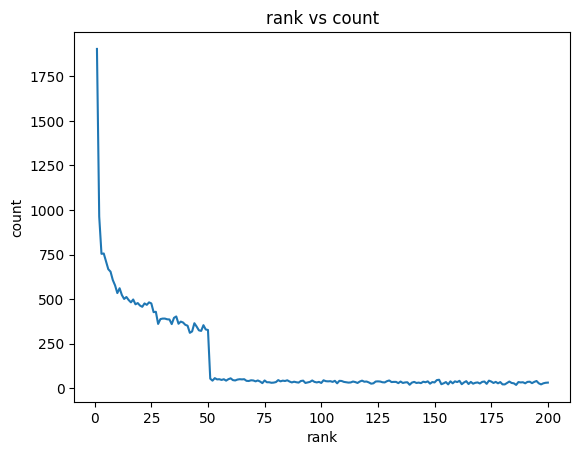

In [117]:
import matplotlib.pyplot as plt
# plot the data
plt.plot(df_final_position)

# set the plot title and axis labels
plt.title('rank vs count')
plt.xlabel('rank')
plt.ylabel('count')

# show the plot
plt.show()

In [118]:
rows_top_ten = len(df_final[(df_final['rank'] <= 10)& (df_final['rank']!= 0)])
rows_top_40 = len(df_final[(df_final['rank'] <= 40)& (df_final['rank']!= 0)])
rows_top_10_40 = len(df_final[(df_final['rank'] <= 40)& (df_final['rank'] >= 10)])
rows_top_40_200 = len(df_final[(df_final['rank'] <= 200)& (df_final['rank']>= 40)])
rows_one = len(df_final[(df_final['rank'] == 1)])
rows_zero = len(df_final[(df_final['rank'] == 0)])
rows_over_200 = len(df_final[(df_final['rank'] >200)])
rows_total = len(df_final)

print("rows top 10:", rows_top_ten, int((rows_top_ten/rows_total)*100))
print("rows top 40:", rows_top_40, int((rows_top_40/rows_total)*100))
print("rows 10 to 40:", rows_top_10_40, int((rows_top_10_40/rows_total)*100))
print("rows 40 to 200:", rows_top_40_200, int((rows_top_40_200/rows_total)*100))
print("rows 1:", rows_one, int((rows_one/rows_total)*100))
#print("rows 0:", rows_zero, int((rows_zero/rows_total)*100))
#print("rows over 200:", rows_over_200, int((rows_over_200/rows_total)*100))
print("total rows:", rows_total)

rows top 10: 8129 27
rows top 40: 21252 70
rows 10 to 40: 13657 45
rows 40 to 200: 9142 30
rows 1: 1903 6
total rows: 30038


## Visualizing Trends Over Time

Before modeling and making predictions about what features contribute to a song's success, lets do some explorative data analysis to understand the data better. We'll explore and visualize the answers to questions such as

- Have tastes in music been changing over time?



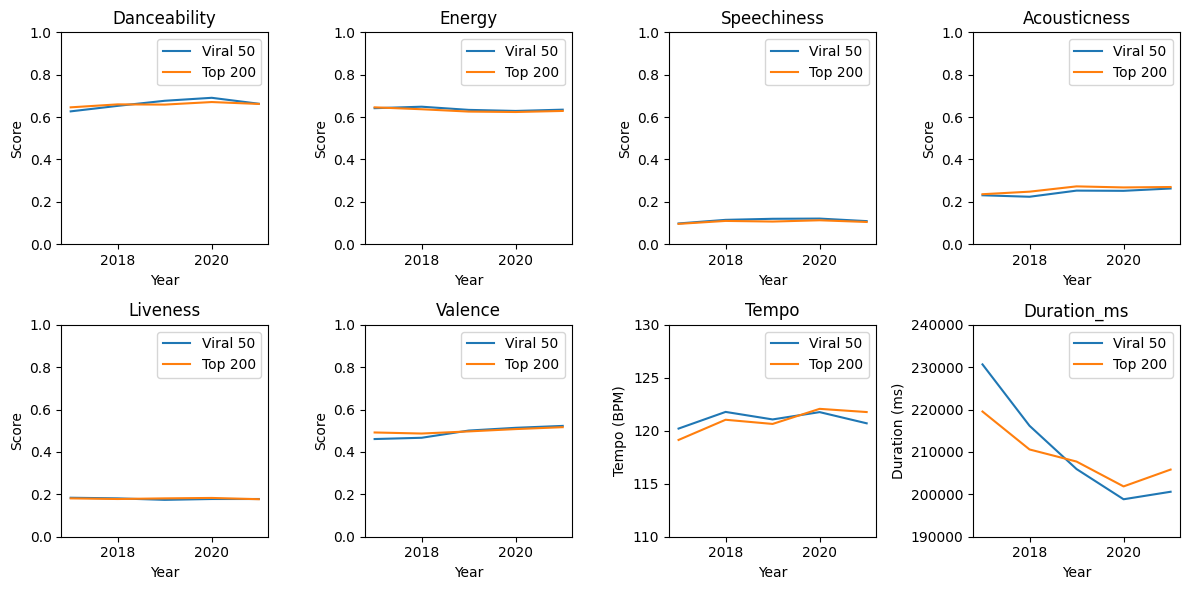

In [119]:
# Lets get the average audio feature in every country in every year
viral50_average_features = df_viral50_features[['Year', 'danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']].groupby(by=['Year'], as_index=False).mean().round(3)
top200_average_features = df_top200_features[['Year', 'danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']].groupby(by=['Year'], as_index=False).mean().round(3)

# define the size of each subplot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# iterate through each feature and plot it in a subplot
for i, feature in enumerate(['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms']):
    ax = axes[i//4, i%4]
    viral50_average_features.plot(x='Year', y=feature, ax=ax, label='Viral 50')
    top200_average_features.plot(x='Year', y=feature, ax=ax, label='Top 200')
    ax.set_title(feature.capitalize())
    ax.set_xlabel('Year')
    ax.set_ylabel('Score')
    
    if feature in ['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']:
        ax.set_ylim(0, 1)
    elif feature == 'tempo':
        ax.set_ylim(110, 130)
        ax.set_ylabel('Tempo (BPM)')
    elif feature == 'duration_ms':
        ax.set_ylim(190000, 240000)
        ax.set_ylabel('Duration (ms)')

plt.tight_layout()
plt.legend()
plt.show()

The most significant change, which seems true, is that average song duration in the charts got shorter from 2017 to 2021, from roughly 3 min 40 seconds to roughly 3 min 25 seconds. It is worth noting that the averages calculated above include multiple entries per song if it charted in multiple countries. The effect is that the more popular a song is worldwide, the more heavily its features are weighted in the graphs above.

## Are There Natural Groupings of Popular Styles of Music?

Subjectively, we have experienced that there are different styles of popular music. Dance music, acoustic singer-songwriter, electronic, etc., may be among the different types of charting popular music. Is it possible to identify an natural clusters of songs in the charts based on audio feature or lyric sentiment?

We'll experiment with K-Means Clustering to see if any natural groupings emerge.

First, lets decide on which features are relevant to the k-means clustering. For example, song title, artist, and year are not relevant.

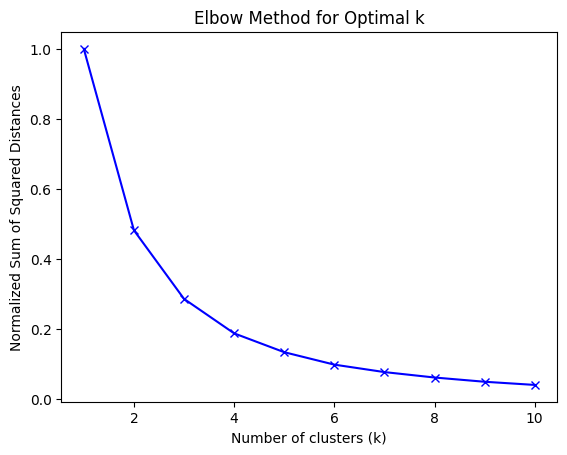

In [120]:
possibly_relevant_features = ['duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness', 'sentiment', 'word_counts', 'unique_word_counts']

# create an empty list to store the sum of squared distances for each k
ssd = []
k_range = range(1, len(possibly_relevant_features))

# fit KMeans for each k value and record the sum of squared distances
for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(df_final[possibly_relevant_features])
    ssd.append(km.inertia_)
# plot the elbow curve
plt.plot(k_range, [x/max(ssd) for x in ssd], 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Normalized Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

It looks like k=6 clusters contains 90 percent of the information of natural groupings, at which point there are diminishing returns for increasing k. Is it possible to narrow down the subset of features that contain most of the information of natural groupings?

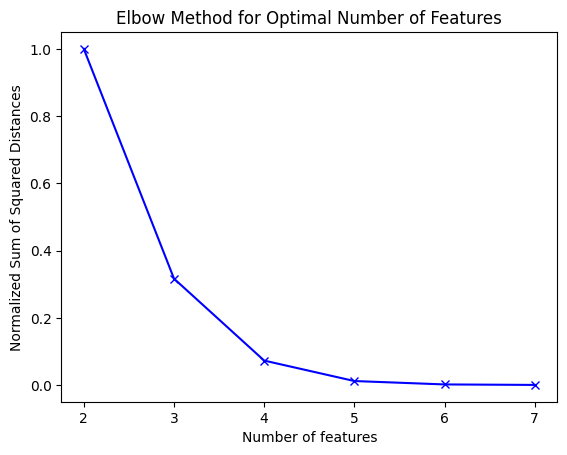

In [121]:
import itertools
import math

feature_cols = ['duration_ms', 'tempo', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness', 'sentiment','word_counts', 'unique_word_counts']
n_features = 7

ssd_results = [math.inf] * (n_features-1)
subsets = [0] * (n_features-1)

for r in range(2, n_features+1):
    for subset in itertools.combinations(feature_cols, r):
        subset = list(subset)
        # since prev r-1 feature subset explained the most of the clustering, next feature subset should include those features. speeds up run time
        if r > 2 and not set(subsets[r-3]).issubset(set(subset)):
          continue
        km = KMeans(n_clusters=6, init='k-means++', random_state=42)
        km.fit(df_final[subset])
        # below, "/10**(r-1)" is a scaling factor so we can compare the sum mean squared distances of the k means clustering over different dimensions
        # We divide the sum of distances in two dimensions by 10^0. Divide the sum of distances in three dimensions by 10^1. In four dimensions, 10^2...
        if km.inertia_ / 10**(r-2) < ssd_results[r-2]:
          ssd_results[r-2] = km.inertia_ / 10**(r-2)  
          subsets[r-2] = subset

# plot the elbow curve for each subset of features
plt.plot(range(2, n_features+1), [x/max(ssd_results) for x in ssd_results], 'bx-')
plt.xlabel('Number of features')
plt.ylabel('Normalized Sum of Squared Distances')
plt.title('Elbow Method for Optimal Number of Features')
plt.show()

Clearly four or five features is the point at which we start seeing diminishing returns. Which features are those that contain the most information with respect to natural clustering? The five most relevant features for explaining the natural gourpings are:

In [151]:
k_means_feature_subset = subsets[3]
subsets[3]

['energy', 'danceability', 'liveness', 'acousticness', 'speechiness']

What does this mean? We can notice that, for example, 'sentiment' is not included in the list of features that contain the most information of the natural groupings. This means that while there is variation in sentiment among the songs, two songs with opposite sentiment but with the same energy level are more likely to belong to the same natural group than two songs with opposite energy levels but the same sentiment. Making this more relatable, this is to say that songs that are high energy, danceable, live, acoustic and speechy are most likely to belong to the same group, regardless of whether they contain positive or negative sentiment, are short or long, contain many or few words, etc.

It may be insightful in future modeling to have a cluster label column, which may end up being a strong predictor of success.

In [139]:
km = KMeans(n_clusters=6, init='k-means++', random_state=42)
km.fit(df_final[k_means_feature_subset])
df_final['cluster'] = km.predict(df_final[k_means_feature_subset])
df_final[11000:11005][['title', 'artist','cluster']]  # look at random slice

,title,artist,cluster
11000,How Do I Live,LeAnn Rimes,4
11001,How Do I Live,Trisha Yearwood,1
11002,How Do We Make It,Jarryd James,4
11003,How Do You Do!,Roxette,2
11004,How Do You Feel?,The Maine,2


Lets listen to some music and see if these clusters make sense subjectively!

Cluster 4:

[How Do I Live - LeAnn Rimes](https://youtu.be/1Olo8gzgpC4)

[How Do We Make It - Jarryd James](https://youtu.be/PZY_y-OWw4Y)

Cluster 2:

[How Do You Do! - Roxette](https://youtu.be/nx2iLOvP0rM)

[How Do You Feel? - The Maine](https://youtu.be/tku0H7YeMeA)

Subjectively, these songs in these clusters sound very similar! Interestingly, the second "How Do I Live" song is the same song, but with slightly different instrumentation.

[How Do I Live - Trisha Yearwood](https://youtu.be/Rcy6hNthQaA)

What are the characteristics of each of the clusters?

In [143]:
df_cluster_means = df_final[k_means_feature_subset + ['cluster']].groupby(by=['cluster']).mean()
df_cluster_means

,energy,danceability,liveness,acousticness,speechiness
cluster,,,,,
0,0.654173,0.779638,0.137295,0.115875,0.143596
1,0.332498,0.513531,0.156988,0.785519,0.059789
2,0.845898,0.550176,0.173996,0.050610,0.080229
3,0.749625,0.618028,0.564133,0.143438,0.128032
4,0.527930,0.526578,0.144018,0.175643,0.065120
5,0.601879,0.684772,0.153018,0.501262,0.120671


Some insights that jump out right away are:
- Cluster 0 contains the most danceable and most speechy-sounding songs
- Cluster 1 contains the lowest energy, lowest danceability, least speechy, and most acoustic-sounding songs
- Cluster 2 contains the highest energy and lowest acoustic-sounding songs
- Cluster 3 contains the most "live" sounding songs
- Cluster 4, like cluster 1 contains low-danceability songs, but ones that have low acousticness rather than high.
- Cluster 5 is relatively high in energy and danceability, but unlike clusters 0, 2, and 3, which are also high in danceability and energy, cluster 5 is distinguished by having high acousticness.

Lets create columns for each of these clusters and one-hot encode so they can be used in further machine learning.

In [150]:
clusters = ['genre_dance', 'genre_mellow_acoustic', 'genre_high_energy_non_acoustic', 'genre_live', 'genre_mellow_non_acoustic', 'genre_high_energy_acoustic']
for i in range(6):
  df_final[clusters[i]] = df_final['cluster'].apply(lambda x: 1 if x == i else 0)

And lets reduce the five dimensions that we calculated the k-means clustering over down to two via PCA to visualize the cluster distributions

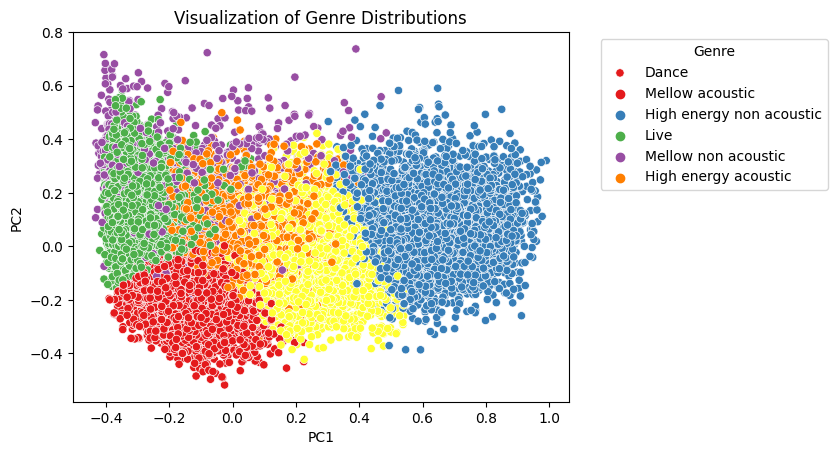

In [175]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_final[k_means_feature_subset])

colors = sns.color_palette('Set1', n_colors=6)

pca_df = pd.DataFrame({'PC1': pca_scores[:,0], 'PC2': pca_scores[:,1], 'cluster': df_final['cluster']})

# Create a scatter plot of the PCA scores, colored by genre
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=[clusters[i].replace('_', ' ').replace('genre ', '').capitalize() for i in range(6)], title='Genre')
plt.title('PCA Visualization of Genre Distributions')
plt.show()


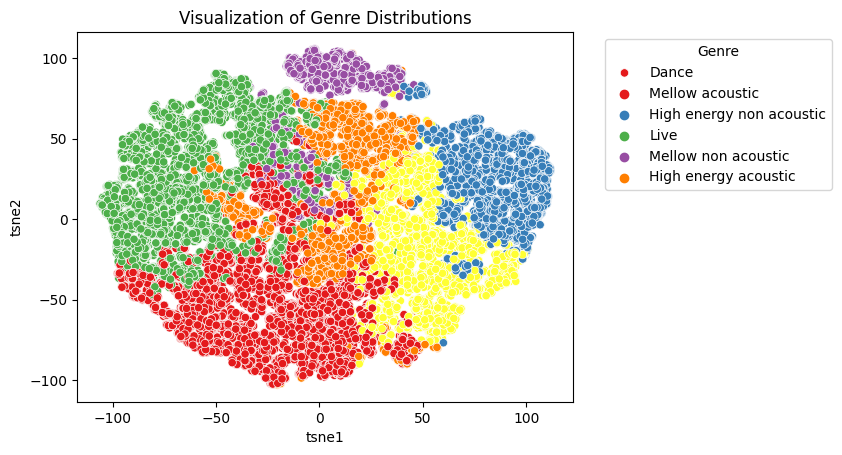

In [176]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_scores = tsne.fit_transform(df_final[k_means_feature_subset])

colors = sns.color_palette('Set1', n_colors=6)

tsne_df = pd.DataFrame({'tsne1': tsne_scores[:,0], 'tsne2': tsne_scores[:,1], 'cluster': df_final['cluster']})

# Create a scatter plot of the t-SNE scores, colored by genre
ax = sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette=colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=[clusters[i].replace('_', ' ').replace('genre ', '').capitalize() for i in range(6)], title='Genre')
plt.title('t-SNE Visualization of Genre Distributions')
plt.show()


Joe TODO: 
- Label each song according to its cluster and show average stats for each cluster
- Visualize clusters using PCA and t-SNE
- Look at how average sentiment changes over time